**Assignment Task:** 

Your task is to perform a multiple linear regression analysis to predict the price of Toyota corolla based on the given attributes. 


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


In [25]:
#Load the dataset
df = pd.read_csv("ToyotaCorolla - MLR.csv") 

In [26]:
df.shape

(1436, 11)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age_08_04  1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   Fuel_Type  1436 non-null   object
 4   HP         1436 non-null   int64 
 5   Automatic  1436 non-null   int64 
 6   cc         1436 non-null   int64 
 7   Doors      1436 non-null   int64 
 8   Cylinders  1436 non-null   int64 
 9   Gears      1436 non-null   int64 
 10  Weight     1436 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 123.5+ KB


In [28]:
df.head()

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


In [29]:
df.isnull().sum() #to check is there any null value

Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64

In [30]:
df.duplicated().sum() #to check duplicates

np.int64(1)

In [31]:
df.drop_duplicates(inplace=True) #to remove duplicates

In [32]:
df.duplicated().sum()

np.int64(0)

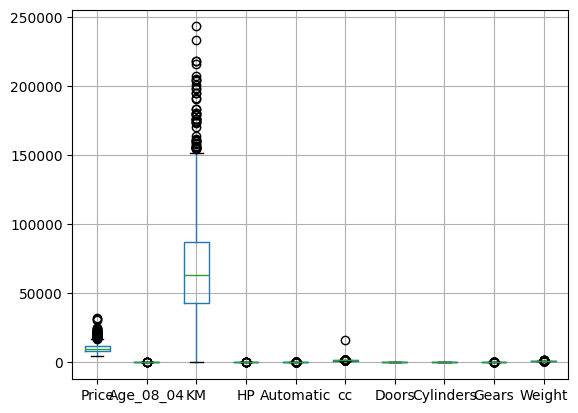

In [33]:
# Check outliers
df.boxplot()
plt.show()

In [34]:
### outlier capping
def outlier_capping(df,column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR= Q3-Q1
    lower_extreme= Q1-1.5*IQR
    upper_extreme= Q3+1.5*IQR
    df[column]= df[column].apply(lambda x: lower_extreme if x<lower_extreme else upper_extreme if x>upper_extreme else x)
for col in df.select_dtypes(['int','float']).columns:
    outlier_capping(df,col)

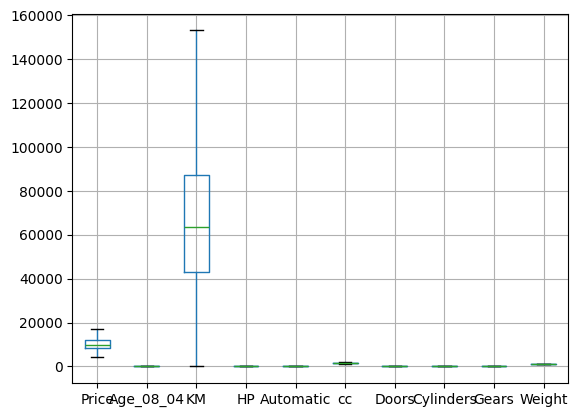

In [35]:
df.boxplot()
plt.show()

In [36]:
#Label Encoding (Fuel Type)
le = LabelEncoder()
df['Fuel_Type'] = le.fit_transform(df['Fuel_Type'])
print("Fuel Type Classes:", le.classes_)

Fuel Type Classes: ['CNG' 'Diesel' 'Petrol']


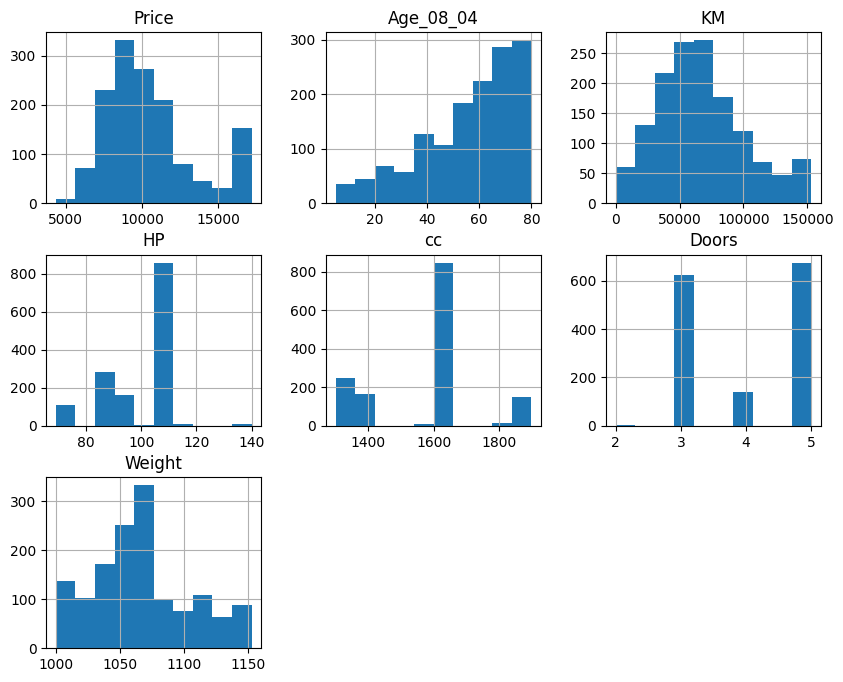

In [37]:
#Histograms
df[['Price','Age_08_04','KM','HP','cc','Doors','Weight']].hist(figsize=(10,8))
plt.show()


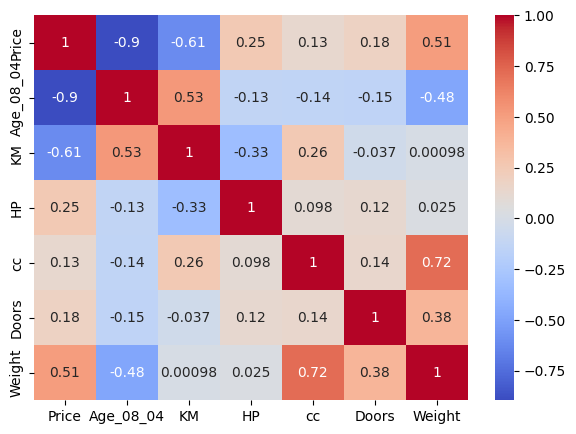

In [38]:
# Heatmap
plt.figure(figsize=(7,5))
sns.heatmap(df[['Price','Age_08_04','KM','HP','cc','Doors','Weight']].corr(),
            annot=True, cmap='coolwarm')
plt.show()

In [39]:
# Features & Target
features = df[['Age_08_04','KM','Fuel_Type','HP','Automatic','cc','Doors','Weight']]
target = df['Price']


In [40]:
#Train/Test Split (We divide data into train (80%) & test (20%) sets.)
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.80, random_state=100)

print("x_train:", x_train.shape)
print("x_test :", x_test.shape)


x_train: (1148, 8)
x_test : (287, 8)


In [41]:
#Scaleing Numerical Features
scaler = StandardScaler()
num_cols = ['Age_08_04','KM','HP','Automatic','cc','Doors','Weight']

x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

In [42]:
# VIF (Multicollinearity Check)
vif_df = pd.DataFrame()
vif_df["Feature"] = x_train.columns
vif_df["VIF"] = [variance_inflation_factor(x_train.values, i)
                 for i in range(x_train.shape[1])]
vif_df

,Feature,VIF
0,Age_08_04,2.232647
1,KM,1.979083
2,Fuel_Type,1.025757
3,HP,1.269776
4,Automatic,NaN
5,cc,2.893016
6,Doors,1.285840
7,Weight,3.835221


In [43]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

y_pred_test = lin_model.predict(x_test)
y_pred_train = lin_model.predict(x_train)

print("----- Linear Regression -----")
print("Train R² :", r2_score(y_train, y_pred_train))
print("Test R²  :", r2_score(y_test, y_pred_test))
print("MSE Test :", mean_squared_error(y_test, y_pred_test))


----- Linear Regression -----
Train R² : 0.8689916567072791
Test R²  : 0.8502399214923704
MSE Test : 1269017.8863630767


In [44]:
n = x_test.shape[0]
p = x_test.shape[1]

r2 = r2_score(y_test, y_pred_test)
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

residuals = y_test - y_pred_test
rss = np.sum(residuals**2)

aic = n * np.log(rss/n) + 2*p
bic = n * np.log(rss/n) + p * np.log(n)

print("Adjusted R²:", adj_r2)
print("AIC:", aic)
print("BIC:", bic)


Adjusted R²: 0.8459302789453882
AIC: 4049.4273524949886
BIC: 4078.7032102210655


In [45]:
ridge = Ridge(alpha=1.0)
ridge.fit(x_train, y_train)

y_pred_ridge = ridge.predict(x_test)

print("\n Ridge Regression Results")
print("MSE  :", mean_squared_error(y_test, y_pred_ridge))
print("R2   :", r2_score(y_test, y_pred_ridge))



 Ridge Regression Results
MSE  : 1269354.9613385238
R2   : 0.8502001424038892


In [46]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)

y_pred_lasso_test = lasso.predict(x_test)
y_pred_lasso_train = lasso.predict(x_train)

print("----- Lasso Regression -----")
print("Train R² :", r2_score(y_train, y_pred_lasso_train))
print("Test R²  :", r2_score(y_test, y_pred_lasso_test))
print("MSE Test :", mean_squared_error(y_test, y_pred_lasso_test))


----- Lasso Regression -----
Train R² : 0.8689916278259502
Test R²  : 0.8502381055440648
MSE Test : 1269033.2741146297


#### Robust regression is only needed if outliers are still affecting the model heavily, even after outlier treatment.
* We already capped outliers using IQR.
* R² scores are stable
* No extreme overfitting between train & test

### Conclusion

- Linear Regression provides strong baseline performance
- Ridge Regression slightly improves generalization by reducing overfitting
- Lasso Regression performs similarly while shrinking weak feature weights

### Interview Questions & Answers

 **1. What is Normalization & Standardization and how is it helpful?**

**Normalization**  
- Rescales data to a fixed range, usually **0 to 1**.  
- Formula: (x - min) / (max - min)  
- Helps when features have very different scales.  
- Used in distance-based algorithms like KNN, Neural Networks.

**Standardization**  
- Converts data to **mean = 0** and **standard deviation = 1**.  
- Formula: (x - mean) / std  
- Essential for algorithms like **Linear Regression, Ridge, Lasso, SVM**.  
- Ensures stable coefficient estimation and prevents dominance of large-scale features.

 **Why helpful?**  
- Improves training speed  
- Prevents scale imbalance  
- Avoids biased coefficients  
- Required for regularization methods  



 **2. What techniques can be used to address multicollinearity in Multiple Linear Regression?**

**Multicollinearity** = When independent variables are highly correlated  
→ causes unstable coefficients & inflated variance.

 **Ways to handle it:**

1. **Variance Inflation Factor (VIF)**  
   - Identify variables with VIF > 5 or 10  
   - Remove or modify those predictors  

2. **Correlation Matrix**  
   - Detect highly correlated feature pairs  
   - Remove one of them  

3. **Ridge Regression (L2 Regularization)**  
   - Shrinks coefficients  
   - Best for dealing with multicollinearity  

4. **Lasso Regression (L1 Regularization)**  
   - Performs feature selection  
   - Eliminates unnecessary variables  


